# Exponential Mixture Models and the EM Algorithm

This notebook explores Exponential mixture models, their esitmation, resulting classification, and the EM algorithm when labels are not provided.

In [1]:
import numpy as np  # for numerical python libraries

import scipy.stats as st  # for statistical libraries

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Generate some random Exponential mixture model data
In the mixture model, a generative model, the probability that a point in feature space is generated is Gaussian with a class specific mean and covariance matrix

In [2]:
# prior distribution over hidden states
pi=np.array([0.5,0.25,0.25])

# intensity conditional on hidden state 
# (here we have two visible exponential variables)
lmbda=np.array([[1,10],[2,1],[4,0.6]])

In [3]:
def GenerateData(pi,lmbda,N):
    # this function simply generates exponential mixture model  data 
    # pi represents the probability of each class (in this case, we have 3)
    # lmbda are the vector of intensities for each state
    
    d = lmbda.shape[1] # data dimension
    K = pi.size # number of classes
    
    X = np.zeros((N,d)) # store features (i.e., the visible inter-arrival times)
    Y = np.zeros(N) # store labels (these are not visibile to us when we have real data, but we store them for experimentation)
    Y = Y.astype(int)
    
    # used generate random labels
    cpi = np.cumsum(pi)
    U = np.random.uniform(0,1,N)
        
    for i in range(0,N):
    
        # generate a label for point i
        Y[i] = int(sum(U[i] > cpi))
    
        # generate random point in feature space conditional on being in class Y[i]
        for j in range(0,d):
            X[i,j] = np.random.exponential(1/lmbda[Y[i],j])
    
    return X,Y
    

## Plot a random sample

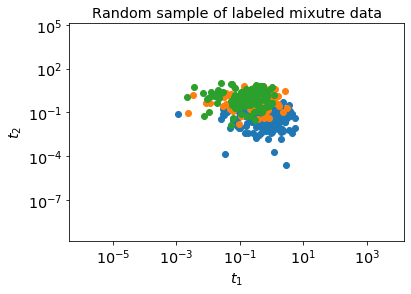

In [4]:
t,y =  GenerateData(pi,lmbda,500) #generate the mvn data

ax = plt.subplot(1,1,1)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

for i in range(0,lmbda.shape[0]):
    plt.scatter(t[y==i,0],t[y==i,1]) # plotting the points
    
plt.xlabel(r'$t_1$')    
plt.ylabel(r'$t_2$')
plt.title('Random sample of labeled mixutre data')

plt.show()

## Estimate the model from the data using labels

In [5]:
def EstimateMixtureModel(t,y): #No EM here - this is straight up classification with known labels
    
    Y = np.unique(y) # get the unique list of labels
    K = Y.size # number of unique labels
    d = t.shape[1]
    
    pi = np.zeros(K) 
    lmbda = np.zeros((K,d)) 
    
    # estimate the parameters for every unique point with the MLE estimates 
    for k in range(K):
        idx = (y==Y[k])
        pi[k] = np.sum(idx)/y.size
        for j in range(d):
            lmbda[k,j] = 1/np.mean(t[idx,j])
        
    return pi, lmbda

In [6]:
pih,lmbdah = EstimateMixtureModel(t,y)

print(pih)
print(lmbdah)

[0.506 0.254 0.24 ]
[[0.98027245 9.02516435]
 [2.15256329 0.83039297]
 [3.76774373 0.56241834]]


# Bayes classifier
This provides the (posterior) probability that a point in feature space comes from a given class $\gamma_{k}(x)=\mathbb P(T=t|Y=k)$ and equals using Bayes rule

$$
\gamma_{k}(t) = \frac{\pi_k \; f_{T|Y=k}(t; \lambda_k)}{\sum_{k\in{\mathcal K}} \pi_k \;f_{T|Y=k}(t; \lambda_k)}
$$

In [7]:
# compute the posterior probability of a point in feature space being from a given class
def Posterior(pi,lmbda,bins):
    K = pi.size
    
    nbins = bins.shape[1]
    p = np.zeros((K,nbins,nbins))
    
    for i in range(0,nbins):
        for j in range(0,nbins):
                 
            denom = 0
            # for every quantile, calculate the probability of it being in a certain class
            # divide by the sum of probabilities for that point, across that class
            # what results is the probability of the point (i,j) being in class k
            for k in range(0,K):
                p[k,i,j] = pi[k]*(lmbda[k,0]*np.exp(-bins[0,i]*lmbda[k,0]))*(lmbda[k,1]*np.exp(-bins[1,j]*lmbda[k,1]))
                denom += p[k,i,j]

            for k in range(0,K):
                 p[k,i,j] /= denom
                 
    return p

In [8]:
# use the true and estimated model parameters to compute the posterior
bins=np.zeros((2,100))
bins[0,:] = np.exp(np.linspace(np.log(1e-4),np.log(100),100))
bins[1,:] = np.exp(np.linspace(np.log(1e-4),np.log(100),100))

p = Posterior(pi,lmbda,bins)
ph = Posterior(pih,lmbdah,bins)

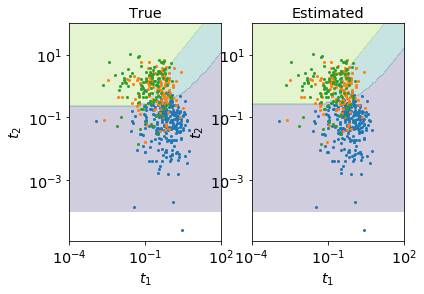

In [9]:
# plot the results
ax=plt.subplot(1,2,1)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.contourf(bins[0,:],bins[1,:],np.argmax(p,axis=0).T,2,alpha=0.25)

for i in range(0,lmbda.shape[0]):
    plt.scatter(t[y==i,0],t[y==i,1],s=4)
    
plt.xlabel(r'$t_1$')    
plt.ylabel(r'$t_2$')
plt.title('True')

ax2=plt.subplot(1,2,2)
ax2.set_xscale("log", nonposx='clip')
ax2.set_yscale("log", nonposy='clip')
plt.contourf(bins[0,:],bins[1,:],np.argmax(ph,axis=0).T, 2, alpha=0.25)

for i in range(0,lmbda.shape[0]):
    plt.scatter(t[y==i,0],t[y==i,1],s=4)
    
plt.xlabel(r'$t_1$')    
plt.ylabel(r'$t_2$')
plt.title('Estimated')
plt.show()

# the estimated comes very close to the true. We are able to identify the regions quite well

# Estimating without the labels... EM Algorithm
Responsibilities at iteration m for data point n in class k is
$$
\gamma_{n,k}^m = \frac{\pi_k^m \; f_{T_n|Y_n=k}(t_n; \lambda_k^m)}{\sum_{k\in{\mathcal K}} \pi_k^m \;f_{T_n|Y_n=k}(t_n;  \lambda_k^m)}
$$
where the probability that data point n occurs given that it is in class k is 
$$
f_{T_n|Y_n=k}(t_n; \lambda_k^m) =  \lambda_{k,1}^m e^{-t_{n,1}  \lambda_{k,1}^m}\lambda_{k,2}^m e^{-t_{n,2}  \lambda_{k,2}^m}
$$

In [10]:
# now we actually use EM - we no longer have the labels
# this function represents the e-step
def Reponsibilities(t,pi,lmbda):
    
    K = pi.size
    
    g = np.zeros((K, t.shape[0]))
    
    for n in range(0,t.shape[0]):
        
        denom = 0
                
        for k in range(0,K):
            g[k,n] = pi[k]*(lmbda[k,0]*np.exp(-t[n,0]*lmbda[k,0]))*(lmbda[k,1]*np.exp(-t[n,1]*lmbda[k,1]))
            #posterior probability that point n is in state k
            # similar to what was in the "Bayes" function, except here we are given 
            # a data point as opposed to calculating the probability for an arbitrary point
            # in feature space
            denom += g[k,n]
            
        for k in range(0,K):
            g[k,n] /= denom
            
    return g

The m-step update rules are for class $l$
$$
\pi_l^{m+1} = \frac{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m}{\sum_{n\in\mathcal{N},l\in\mathcal{K}} \gamma_{n,l}^m}
$$

$$
\lambda_{l,i}^{m+1} = \frac{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m}{\sum_{n\in\mathcal{N}} t_{n,i} \,\gamma_{n,l}^m}
$$



In [11]:
def EM(t, pi, lmbda, iter):
    
    K = pi.size
    d = t.shape[1]
        
    for m in range(iter):
        
        # e-step
        gamma = Reponsibilities(t,pi,lmbda)
        
        #m-step
        #
        
        #  compute update to pi
        numer = np.sum(gamma, axis=1) # sum_n  gamma_{n,k} gives array shape (1,K)
        denom = np.sum(numer) # sum_{n,k}  gamma_{n,k}
        pi = numer / denom
        
        #  compute update to lmbda
        denom  = np.matmul(gamma, t)   # sum_n x_{n,l} gamma_{n,k} gives array shape (K,d) 
        for k in range(0,K):
            lmbda[k,:] = numer[k]/denom[k,:]


    print('   -- estimated parameters -----')
    print(pi, '\n\n', lmbda, '\n\n')
            
    return pi, lmbda

In [12]:
def InitialGuess(t,K):
    # generate an initial guess depending on the number of classes that are specified

    pi_h = np.ones(K)/K
    lmbda_h = 1.0/np.mean(t,axis=0)

    pi0 = pi_h * np.random.uniform(0.99,1.01,K)
    pi0 = pi0 / sum(pi0)

    lmbda0 = np.tile(lmbda_h,(K,1)) * np.random.uniform(0.99,1.01,(K,2))
    
    return pi0, lmbda0

In [13]:
def loglike(t,pi,lmbda):
    K = pi.shape[0]
    n = t.shape[0]
    
    gamma = Reponsibilities(t,pi,lmbda)
    logl =0
    for k in range(K):
        for i in range(n):
            logl += gamma[k,i] * ( np.log(pi[k]) + np.log(lmbda[k,0]) - (t[i,0]*lmbda[k,0]) +np.log(lmbda[k,1]) -(t[i,1]*lmbda[k,1]) )
            
    return logl

In [14]:
def BIC(t,pi,lmbda):
    K = pi.shape[0]
    n = t.shape[0]
    
    return -loglike(t,pi,lmbda) + 0.5*(2*K+(K-1))* np.log(n)

In [15]:
# generate an initial guess using a list of classes

Kfitmax = 8 # largest number of possible classes
pe = np.empty((Kfitmax,Kfitmax,bins.shape[1],bins.shape[1]))
pie = np.empty((Kfitmax,Kfitmax))
lmbdae = np.empty((Kfitmax,Kfitmax,2))
bic = np.empty((Kfitmax,1))
ll = np.empty((Kfitmax,1))

# fitting the parameters using 2, 3, ... 8 classes
for Kfit in range (2,Kfitmax+1):
    
    print('-------- Kfit = ', Kfit, '-------- ')
    
    pi0,lmbda0 = InitialGuess(t,Kfit)

    print('   -- initial guess -- ')
    print(pi0, '\n\n', lmbda0, '\n\n')

    # use EM to update the estimate
    thispie, thislmbdae = EM(t, pi0, lmbda0, 100)

    pie[Kfit-1,0:Kfit] = thispie
    lmbdae[Kfit-1,0:Kfit,:] = thislmbdae
    
    pe[Kfit-1,0:Kfit,:,:] = Posterior(thispie,thislmbdae,bins)
    
    bic[Kfit-1] = BIC(t,thispie, thislmbdae)
    ll[Kfit-1] = loglike(t,thispie, thislmbdae)

-------- Kfit =  2 -------- 
   -- initial guess -- 
[0.49809492 0.50190508] 

 [[1.44636115 1.26669531]
 [1.43563871 1.27685289]] 


   -- estimated parameters -----
[0.4794008 0.5205992] 

 [[2.83100659 0.65732803]
 [0.98497385 8.77080699]] 


-------- Kfit =  3 -------- 
   -- initial guess -- 
[0.33387791 0.33173456 0.33438753] 

 [[1.43015684 1.26741556]
 [1.43589019 1.28016097]
 [1.43098238 1.2679464 ]] 


   -- estimated parameters -----
[0.22316429 0.4919953  0.28484041] 

 [[2.90940303 0.48481904]
 [0.95724247 9.31730403]
 [2.65698095 1.03366119]] 


-------- Kfit =  4 -------- 
   -- initial guess -- 
[0.2509918  0.24924743 0.25154049 0.24822028] 

 [[1.42474824 1.26282952]
 [1.44115241 1.27729374]
 [1.44058428 1.25794529]
 [1.44479932 1.26478645]] 


   -- estimated parameters -----
[0.12734148 0.3873757  0.26679835 0.21848447] 

 [[ 1.39855492  5.25689672]
 [ 0.89413056 10.55609854]
 [ 2.88303654  0.51983303]
 [ 2.69585245  1.01850799]] 


-------- Kfit =  5 -------- 
   --

In [16]:
def MakePlot(t,Y,bins,atitle, m,n, o):
    ax1=plt.subplot(m, n, o)
    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    plt.contourf(bins[0,:],bins[1,:],Y,np.unique(Y).size-1,alpha=0.25)

    for i in range(0,lmbda.shape[0]):
        plt.scatter(t[y==i,0],t[y==i,1],s=4)

    plt.xlabel(r'$t_1$')    
    plt.ylabel(r'$t_2$')
    plt.title(atitle)

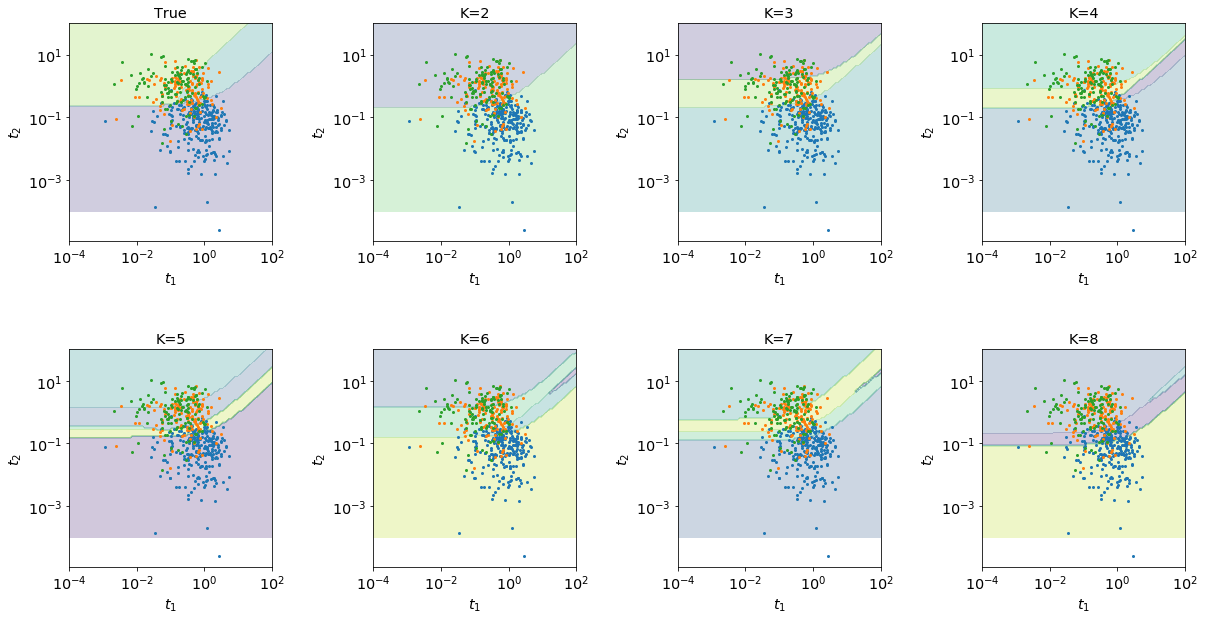

In [17]:
# plot the results
plt.figure(figsize=(20,10))
MakePlot(t,np.argmax(p,axis=0).T,bins,'True', 2, np.ceil(Kfitmax/2),1)


for Kfit in range(2,Kfitmax+1):
    MakePlot(t,np.argmax(pe[Kfit-1,:,:,:],axis=0).T,bins,r'K=' + str(Kfit), 2, np.ceil(Kfitmax/2), Kfit)

plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

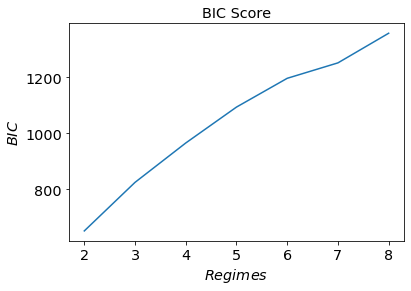

In [18]:
#plot the BIC score for model selection
plt.plot(np.linspace(2,Kfitmax,Kfitmax-1),bic[1:Kfitmax])
plt.xlabel(r'$Regimes$')    
plt.ylabel(r'$BIC$')
plt.title('BIC Score')
plt.show()